# Re-creating Metrics for Previous Test
### Calum Macdonald
Re-creating metrics on previous best test run output to check for errors in my process.

In [5]:
import os,sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from utils import plot_utils
import time
import math
import random
import pdb
from progressbar import *

# Import the utils for plotting the metrics
from plot_utils import notebook_utils_2
from repeating_classifier_training_utils import *

from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [6]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}
label_0 = "e"
label_1 = "mu"
output_path = '/data/WatChMaL/data/resnet_results'
npz_path = os.path.join(os.getcwd(), 'Index_Storage')

## Import previous data and re-order in same order as h5 test set

In [7]:
res_data = np.load(os.path.join(output_path,'test_validation_iteration_dump.npz'),allow_pickle=True)
res_predictions = np.concatenate(list([batch_array for batch_array in res_data['predicted_labels']]))
res_labels = np.concatenate(list([batch_array for batch_array in res_data['labels']]))
res_softmaxes = np.concatenate(list([batch_array for batch_array in res_data['softmax']]))
res_energies = np.concatenate(list([batch_array for batch_array in res_data['energies']]))

In [8]:
mapping_indices = np.load(os.path.join(npz_path,'map_indices_previous_resnet.npz'),allow_pickle=True)['arr_0'].astype(int)
res_predictions = res_predictions[mapping_indices]
res_labels = res_labels[mapping_indices]
res_softmaxes = res_softmaxes[mapping_indices]
res_energies = res_energies[mapping_indices]

## Plot confusion matrix for complete dataset

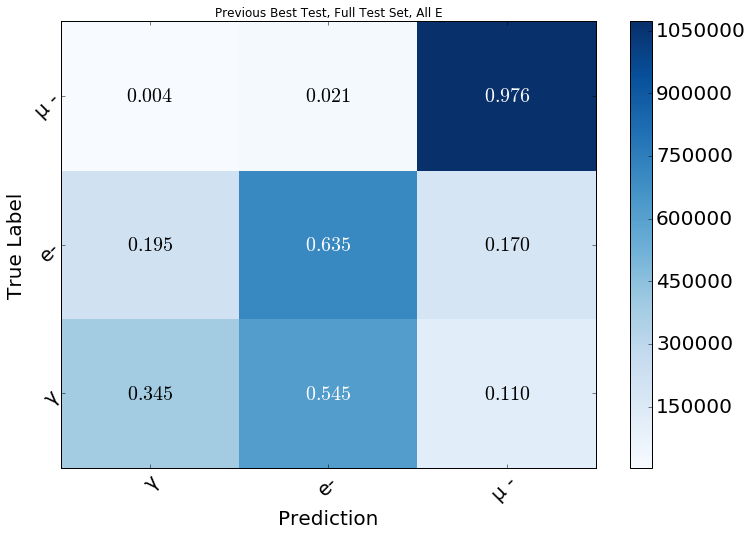

In [6]:
plot_confusion_matrix(res_labels,res_predictions,
                      ['\u03B3','e-','\u03BC -'],title='Previous Best Test, Full Test Set, All E')

## Remove FiTQun Failed Events (events for which FQ produced no output)
Note that the saved failed event indices must be applid to the set BEFORE flagged events are removed

In [23]:
fq_failed_idxs = np.load(os.path.join(os.getcwd(),'Index_Storage/fq_failed_idxs.npz'),allow_pickle=True)['failed_indices_pointing_to_h5_test_set'].astype(int)
print(f"{fq_failed_idxs.shape[0]} events failed.")

2169 events failed.


In [12]:
sres_predictions = np.delete(res_predictions,fq_failed_idxs)
sres_labels = np.delete(res_labels,fq_failed_idxs)
sres_softmaxes = np.delete(res_softmaxes,fq_failed_idxs,0)
sres_energies = np.delete(res_energies,fq_failed_idxs)

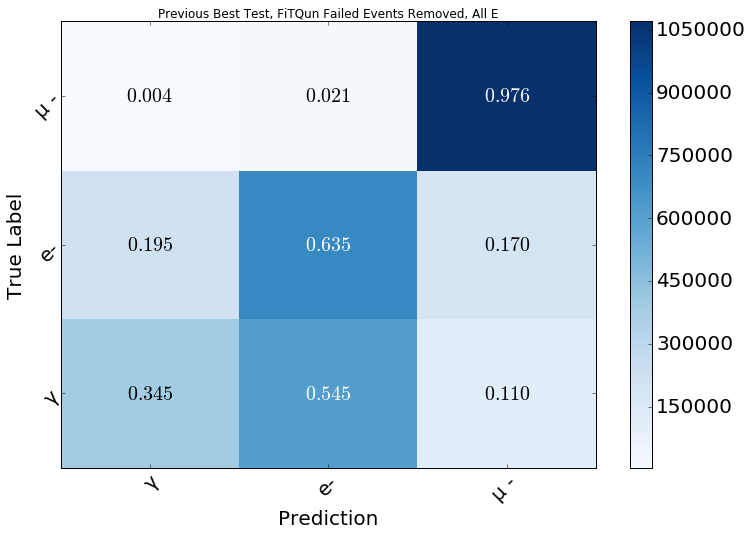

In [9]:
plot_confusion_matrix(sres_labels,sres_predictions,
                      ['\u03B3','e-','\u03BC -'],title='Previous Best Test, FiTQun Failed Events Removed, All E')

## Remove FiTQun Flagged Events
Note that the saved idices must be applied to the set AFTER failed events have been removed

In [24]:
fq_flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'),allow_pickle=True)['arr_0'].astype(int)
print(f"{fq_flagged_idxs.shape[0]} events were flagged")

734514 events were flagged


In [14]:
filtered_res_predictions = np.delete(sres_predictions,fq_flagged_idxs)
filtered_res_labels = np.delete(sres_labels,fq_flagged_idxs)
filtered_res_softmaxes = np.delete(sres_softmaxes,fq_flagged_idxs,0)
filtered_res_energies = np.delete(sres_energies,fq_flagged_idxs)

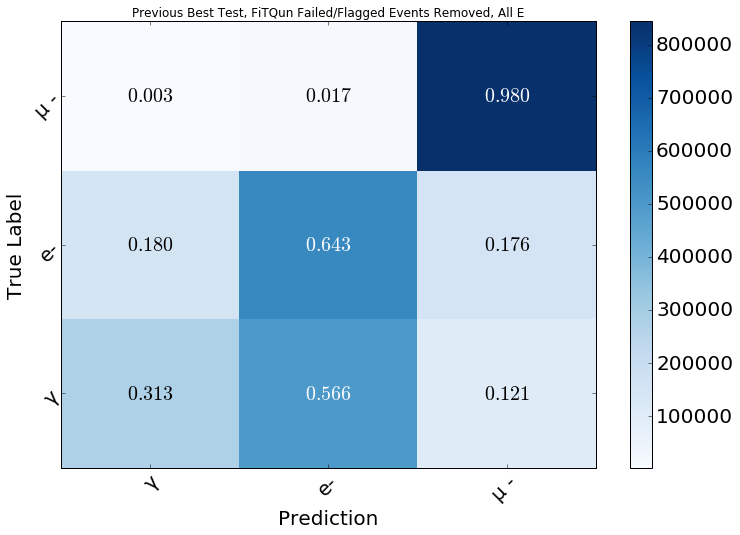

In [12]:
plot_confusion_matrix(filtered_res_labels,filtered_res_predictions,
                      ['\u03B3','e-','\u03BC -'],title='Previous Best Test, FiTQun Failed/Flagged Events Removed, All E')

## Plot ROC Curve for All Energies

In [19]:
res_fpr, res_tpr, res_threshold = prep_roc_data(filtered_res_softmaxes,filtered_res_labels,
                                                filtered_res_energies, softmax_index_dict,
                                                label_0,label_1
                                                )

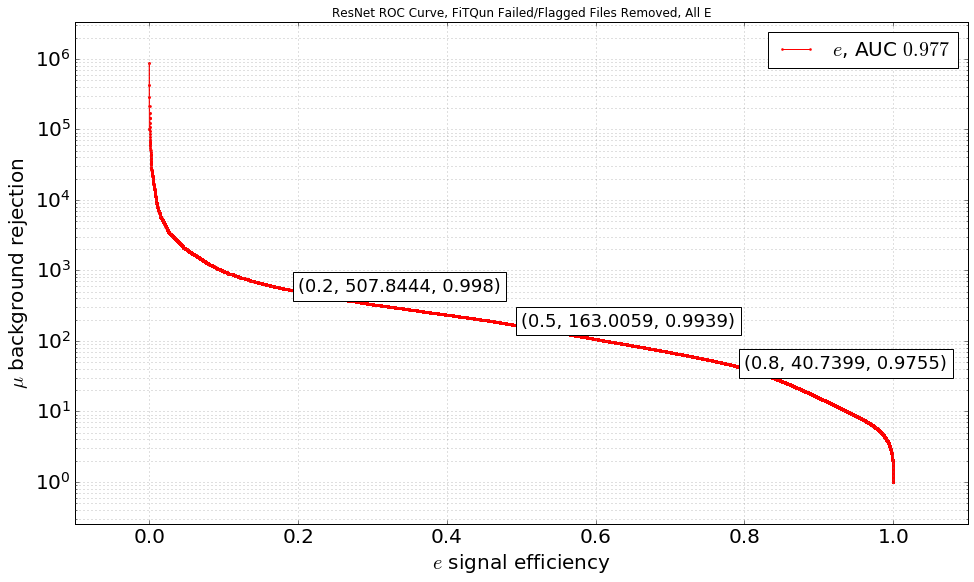

In [20]:
fprs = []
tprs = []
thresholds = []
fprs.append(res_fpr)
tprs.append(res_tpr)
thresholds.append(res_threshold)
roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000,png_name = 'unthresholded_roc.png',title='ResNet ROC Curve, FiTQun Failed/Flagged Files Removed, All E')

## Plot ROC Curve for E < 1000

In [21]:
low_e_res_fpr, low_e_res_tpr, low_e_res_threshold = prep_roc_data(filtered_res_softmaxes,filtered_res_labels,
                                                filtered_res_energies, softmax_index_dict,
                                                label_0,label_1,threshold=1000
                                                )

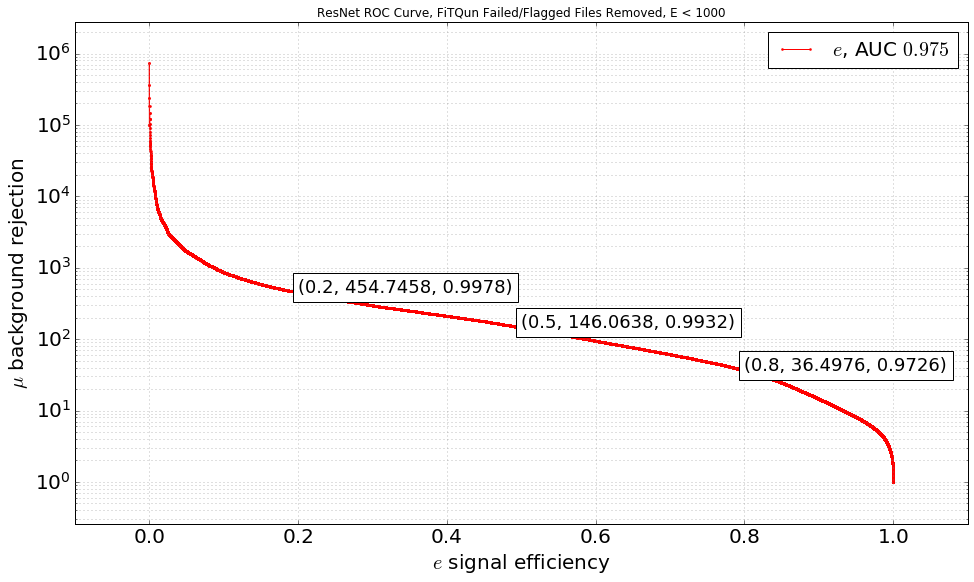

In [22]:
low_e_fprs = []
low_e_tprs = []
low_e_thresholds = []
low_e_fprs.append(low_e_res_fpr)
low_e_tprs.append(low_e_res_tpr)
low_e_thresholds.append(low_e_res_threshold)
roc_metrics = plot_multiple_ROC(low_e_fprs, low_e_tprs, low_e_thresholds, "e", "mu", 0, 1000,png_name = 'thresholded_roc',title='ResNet ROC Curve, FiTQun Failed/Flagged Files Removed, E < 1000')